# _____________ ANÁLISIS PARA 19-04-2023 __________

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Potencia generada por el inversor 

(288, 26)
(145, 3)


/var/folders/pz/w3bcsy5x2wgb_7c0fs6qmkp80000gn/T/ipykernel_29338/3342199884.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SFV['E'] = df_SFV['Producción fotovoltaica'] / (5/60)


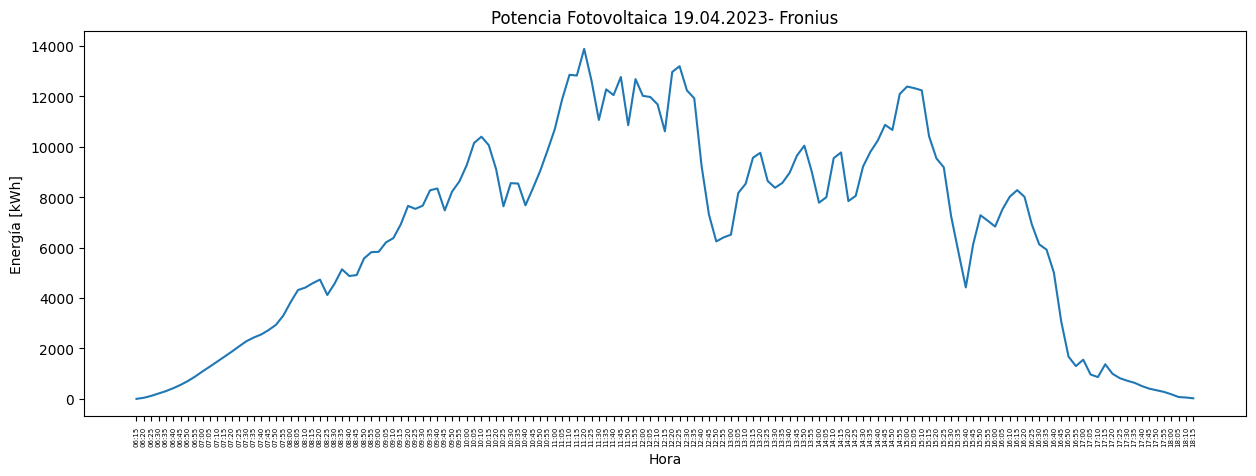

Producción fotovoltaica [kWh/día] = 79.79673999999999
Horas de brillo solar = 4.925724691358023


In [2]:
# leer el archivo csv inversor 
df_fronius = pd.read_csv('../../Data/Processed/SFV_19-04-2023.csv')
print(df_fronius.shape)

# nuevo dataframe con las columnas de hora y producción fotovoltaica
df_SFV = df_fronius[['Hora', 'Producción fotovoltaica']]
df_SFV['E'] = df_SFV['Producción fotovoltaica'] / (5/60)

# valores de 'Potencia' diferentes de cero
df_SFV = df_SFV[df_SFV['E'] != 0]
print(df_SFV.shape)
# graficar la potencia fotovoltaica
plt.figure(figsize=(15, 5))
plt.plot(df_SFV['Hora'], df_SFV['E'])
plt.title('Potencia Fotovoltaica 19.04.2023- Fronius')
plt.xlabel('Hora')
plt.ylabel('Energía [kWh]')
plt.xticks(rotation=90, size=5)
plt.show()
#sumar todos los valores de energía
energia_total = df_SFV['Producción fotovoltaica'].sum()
print("Producción fotovoltaica [kWh/día] =",energia_total/1000)
hbs = energia_total / (30*0.54)
print("Horas de brillo solar =", hbs/1000)



## Importar DB Solcast

In [3]:
# Leer el archivo csv
df_solcast = pd.read_csv('../../Data/Processed/solcast_19-04-2023_PT5M.csv', sep=',')
# Eliminar el primer carácter de 'Time'
df_solcast['Time'] = df_solcast['Time'].str.slice(1)

print(df_solcast.shape)
df_solcast.head()

(288, 12)


,air_temp,albedo,clearsky_ghi,clearsky_gti,cloud_opacity,dewpoint_temp,GHI,gti,period_end,period,Date,Time
0,15,0.14,0,0,65.4,12.7,0,0,2023-04-19T00:00:00Z,PT5M,2023-04-19,19:00
1,15,0.14,0,0,62.3,12.7,0,0,2023-04-19T00:05:00Z,PT5M,2023-04-19,19:05
2,15,0.14,0,0,60.1,12.7,0,0,2023-04-19T00:10:00Z,PT5M,2023-04-19,19:10
3,14,0.14,0,0,56.7,12.7,0,0,2023-04-19T00:15:00Z,PT5M,2023-04-19,19:15
4,14,0.14,0,0,48.4,12.8,0,0,2023-04-19T00:20:00Z,PT5M,2023-04-19,19:20


## Time matching between DB

In [4]:
# hacer math a la columna de 'Time' de df_solcast y la columna 'Hora' de df_SFV y crear un nuevo dataframe
df_solcast['Time'] = pd.to_datetime(df_solcast['Time'])
df_SFV['Hora'] = pd.to_datetime(df_SFV['Hora'])
df = pd.merge(df_solcast, df_SFV, left_on='Time', right_on='Hora')

print(df.shape)
# eliminar las columnas 'albedo' , 'period_end', 'Hora' y 'period'
df = df.drop(['albedo', 'period_end', 'Hora', 'period'], axis=1)
# en la columna 'Time' solo mostrar la hora
df['Time'] = df['Time'].dt.time
#quitarle los segundos al tiempo
df['Time'] = df['Time'].apply(lambda x: x.strftime('%H:%M'))
df.head()

(145, 15)


/var/folders/pz/w3bcsy5x2wgb_7c0fs6qmkp80000gn/T/ipykernel_29338/3806094400.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_solcast['Time'] = pd.to_datetime(df_solcast['Time'])
/var/folders/pz/w3bcsy5x2wgb_7c0fs6qmkp80000gn/T/ipykernel_29338/3806094400.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_SFV['Hora'] = pd.to_datetime(df_SFV['Hora'])


,air_temp,clearsky_ghi,clearsky_gti,cloud_opacity,dewpoint_temp,GHI,gti,Date,Time,Producción fotovoltaica,E
0,12,11,9,49.6,12.1,6,5,2023-04-19,06:15,0.05,0.60
1,12,24,15,29.2,12.0,17,17,2023-04-19,06:20,3.58,42.96
2,12,39,19,26.2,12.0,29,28,2023-04-19,06:25,9.77,117.24
3,12,55,25,35.0,12.0,36,34,2023-04-19,06:30,17.51,210.12
4,12,72,36,32.1,12.0,49,48,2023-04-19,06:35,25.49,305.88


## Análisis de las variables 

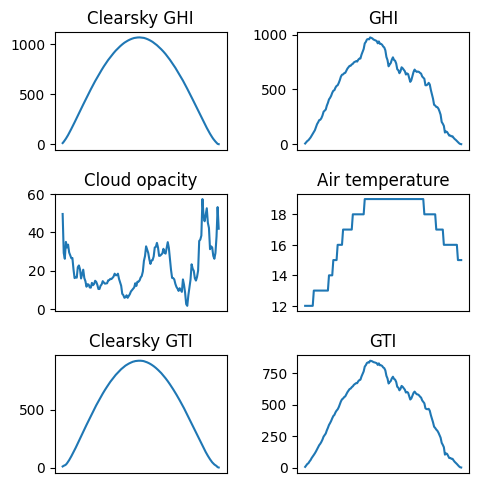

In [5]:
# multiplos graficos de todas las columnas de row_day
fig, ax = plt.subplots(3, 2, figsize=(5, 5))  # 3 filas, 2 columnas
# cuadricula de subplots
plt.tight_layout()

# ajustar espacio entre subplots
# ax[0, 0] clearsky_ghi
ax[0, 0].plot(df['Time'], df['clearsky_ghi'])
ax[0, 0].set_title('Clearsky GHI')
ax[0, 0].get_xaxis().set_visible(False)
# ax[0, 1] GHI
ax[0, 1].plot(df['Time'], df['GHI'])
ax[0, 1].set_title('GHI')
ax[0, 1].get_xaxis().set_visible(False)
# ax[1, 0] cloud_opacity
ax[1, 0].plot(df['Time'], df['cloud_opacity'])
ax[1, 0].set_title('Cloud opacity')
ax[1, 0].get_xaxis().set_visible(False)
# ax[1, 1] air_temp
ax[1, 1].plot(df['Time'], df['air_temp'])
ax[1, 1].set_title('Air temperature')
ax[1, 1].get_xaxis().set_visible(False)
# ax[2, 0] clearsky_gti
ax[2, 0].plot(df['Time'], df['clearsky_gti'])
ax[2, 0].set_title('Clearsky GTI')
ax[2, 0].get_xaxis().set_visible(False)
# ax[2, 1] gti 
ax[2, 1].plot(df['Time'], df['gti'])
ax[2, 1].set_title('GTI')
ax[2, 1].get_xaxis().set_visible(False)

plt.show()




## Potencia calculada a partir de solcast (GHI)

In [6]:
efficiency = 0.2094  # Eficiencia del panel solar
catidad_pv= 30
area =2.274*1.134

df['P'] = df['GHI'] * efficiency *  area * catidad_pv 

## Potencia calculada a partir de fronius 


In [7]:
df['Potencia'] = df['Producción fotovoltaica'] / (5/60)

## Energía a partir de la potencia calculada

Energía calculada solacast [kWh] = 102.783088955988
Energía calculada fronius [kWh] = 79.79673999999999
Error porcentual: 28.80612535798833 %


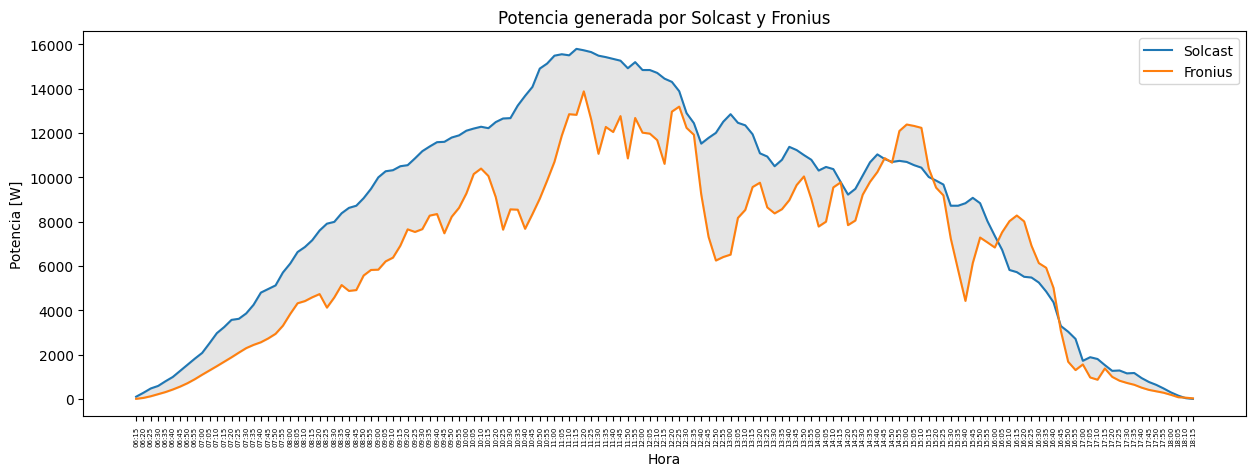

In [8]:
# suma de la potencia generada solcast
energia = df['P']*(5/60)
print("Energía calculada solacast [kWh] =",energia.sum()/1000)

# suma de la potencia generada fronius
energia_fronius = df['Potencia']*(5/60)
print("Energía calculada fronius [kWh] =",energia_fronius.sum()/1000)

# error porcentual
error = abs(  energia.sum() - energia_fronius.sum()) / energia_fronius.sum() * 100
print('Error porcentual:', error, '%')

# graficar la energía generada por solcast y fronius
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['P'], label='Solcast')
plt.plot(df['Time'], df['Potencia'], label='Fronius')
# grafico area bajo la curva
plt.fill_between(df['Time'], df['P'], df['Potencia'], color='gray', alpha=0.2)
plt.title('Potencia generada por Solcast y Fronius')
plt.xlabel('Hora')
plt.ylabel('Potencia [W]')
plt.legend()
plt.xticks(rotation=90, size=5)
plt.show()

## Potencia y Energía calculada a partir de solcast (clearsky_ghi)

In [9]:
df['P_clearsky'] = df['clearsky_ghi'] * efficiency *  area * catidad_pv 

Energía calculada solacast [kWh] = 125.81336946754799
Energía calculada fronius [kWh] = 79.79673999999999
Error porcentual: 57.66730503971467 %


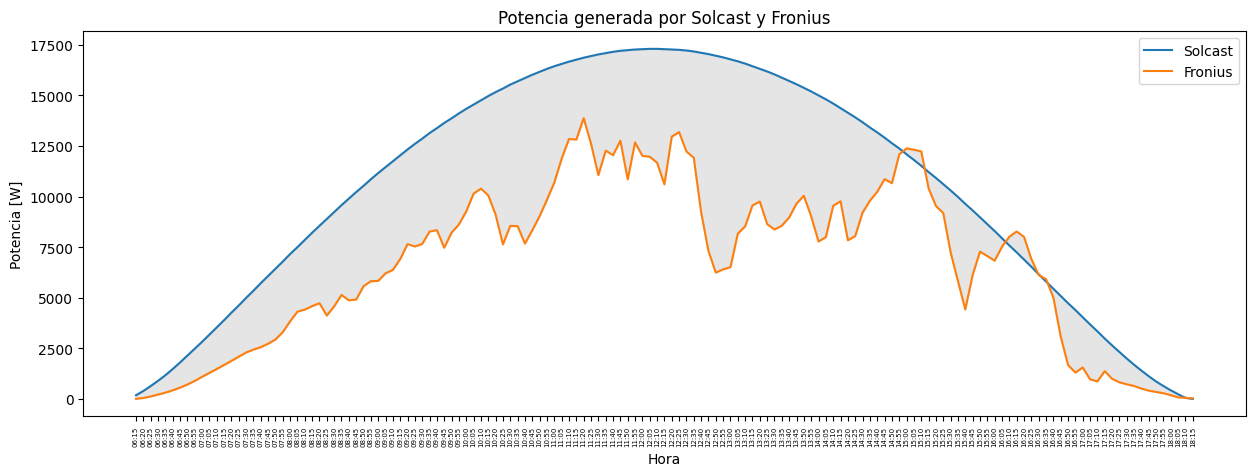

In [10]:
# suma de la potencia generada solcast
energia = df['P_clearsky']*(5/60)
print("Energía calculada solacast [kWh] =",energia.sum()/1000)

# suma de la potencia generada fronius
energia_fronius = df['Potencia']*(5/60)
print("Energía calculada fronius [kWh] =",energia_fronius.sum()/1000)

# error porcentual
error = abs(  energia.sum() - energia_fronius.sum()) / energia_fronius.sum() * 100
print('Error porcentual:', error, '%')

# graficar la energía generada por solcast y fronius
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['P_clearsky'], label='Solcast')
plt.plot(df['Time'], df['Potencia'], label='Fronius')
# grafico area bajo la curva
plt.fill_between(df['Time'], df['P_clearsky'], df['Potencia'], color='gray', alpha=0.2)
plt.title('Potencia generada por Solcast y Fronius')
plt.xlabel('Hora')
plt.ylabel('Potencia [W]')
plt.legend()
plt.xticks(rotation=90, size=5)
plt.show()

## Potencia y Energía calculada a partir de solcast (clearsky_gti)

In [11]:
df['P_clearsky'] = df['clearsky_gti'] * efficiency *  area * catidad_pv 

Energía calculada solacast [kWh] = 105.740846552754
Energía calculada fronius [kWh] = 79.79673999999999
Error porcentual: 32.51273993493219 %


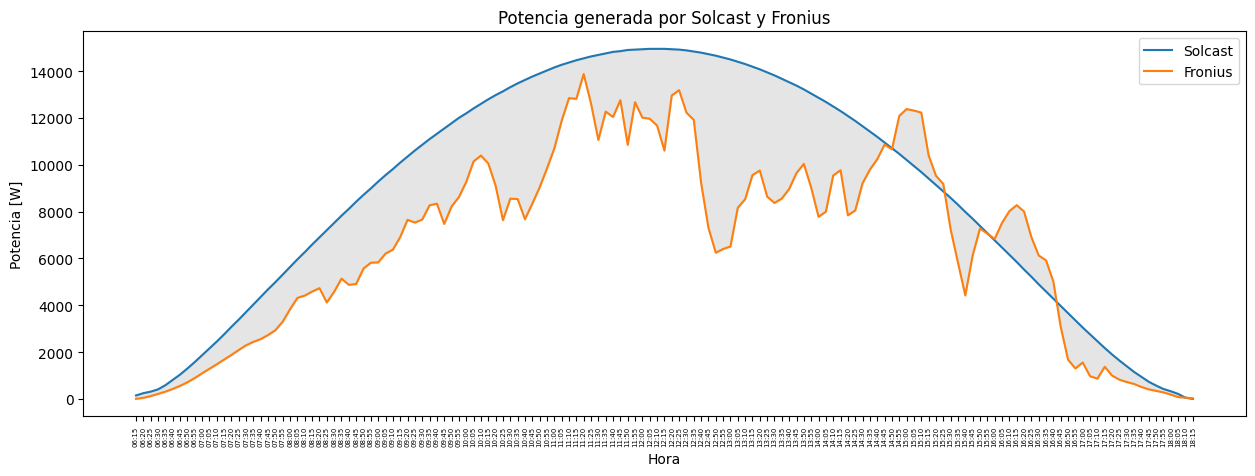

In [12]:
# suma de la potencia generada solcast
energia = df['P_clearsky']*(5/60)
print("Energía calculada solacast [kWh] =",energia.sum()/1000)

# suma de la potencia generada fronius
energia_fronius = df['Potencia']*(5/60)
print("Energía calculada fronius [kWh] =",energia_fronius.sum()/1000)

# error porcentual
error = abs(  energia.sum() - energia_fronius.sum()) / energia_fronius.sum() * 100
print('Error porcentual:', error, '%')

# graficar la energía generada por solcast y fronius
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['P_clearsky'], label='Solcast')
plt.plot(df['Time'], df['Potencia'], label='Fronius')
# grafico area bajo la curva
plt.fill_between(df['Time'], df['P_clearsky'], df['Potencia'], color='gray', alpha=0.2)
plt.title('Potencia generada por Solcast y Fronius')
plt.xlabel('Hora')
plt.ylabel('Potencia [W]')
plt.legend()
plt.xticks(rotation=90, size=5)
plt.show()

## Potencia y Energía calculada a partir de solcast (gti)

In [13]:
df['P_gti'] = df['gti'] * efficiency *  area * catidad_pv 

Energía calculada solacast [kWh] = 90.96825806283599
Energía calculada fronius [kWh] = 79.79673999999999
Error porcentual: 13.99996799723397 %


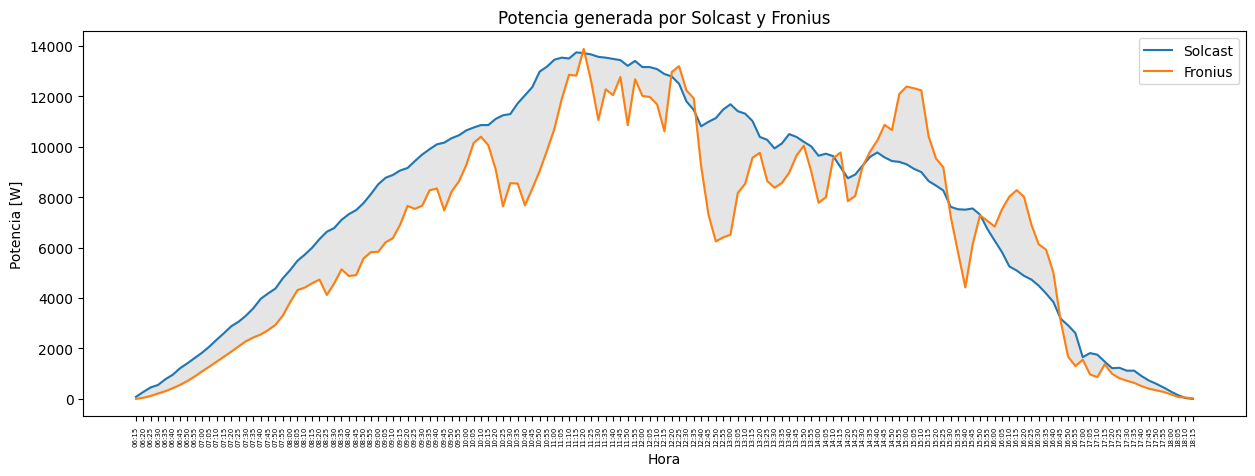

In [14]:
# suma de la potencia generada solcast
energia = df['P_gti']*(5/60)
print("Energía calculada solacast [kWh] =",energia.sum()/1000)

# suma de la potencia generada fronius
energia_fronius = df['Potencia']*(5/60)
print("Energía calculada fronius [kWh] =",energia_fronius.sum()/1000)

# error porcentual
error = abs(  energia.sum() - energia_fronius.sum()) / energia_fronius.sum() * 100
print('Error porcentual:', error, '%')

# graficar la energía generada por solcast y fronius
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['P_gti'], label='Solcast')
plt.plot(df['Time'], df['Potencia'], label='Fronius')
# grafico area bajo la curva
plt.fill_between(df['Time'], df['P_gti'], df['Potencia'], color='gray', alpha=0.2)
plt.title('Potencia generada por Solcast y Fronius')
plt.xlabel('Hora')
plt.ylabel('Potencia [W]')
plt.legend()
plt.xticks(rotation=90, size=5)
plt.show()

## Análisis modelo matemático

## Nubosidad

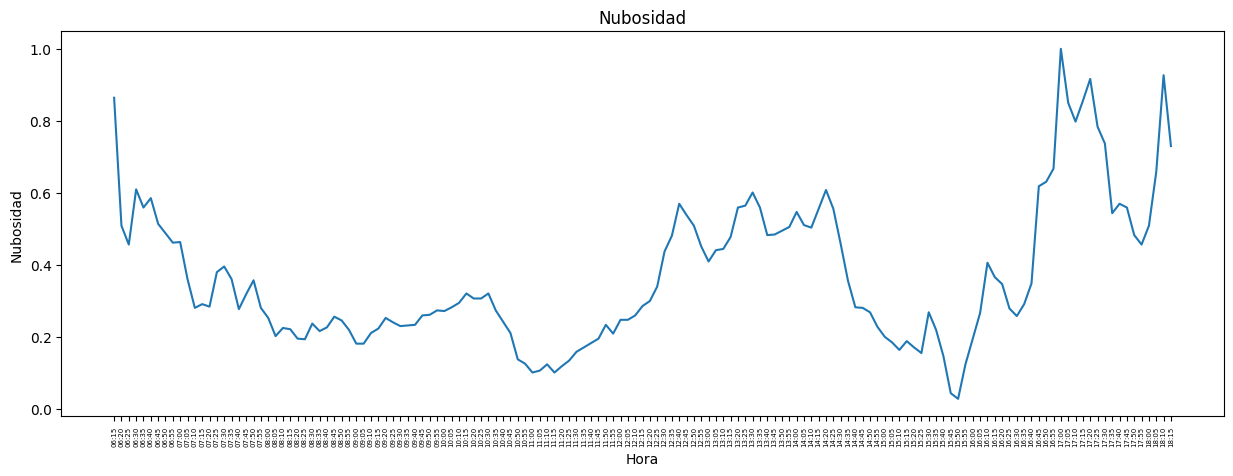

In [15]:
# normalizar 'cloud_opacity' de 0 a 1  en donde 1 es el valor más alto
df['cloud_opacity'] = df['cloud_opacity'] / df['cloud_opacity'].max()

# graficar la nubosidad
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['cloud_opacity'])
plt.title('Nubosidad')
plt.xlabel('Hora')
plt.ylabel('Nubosidad')
plt.xticks(rotation=90, size=5)
plt.show()


## Potencia calulada teniendo en cuenta gti y la nubosidad 

In [16]:
df['P_cloud_opacity'] = df['gti'] * efficiency *  area * catidad_pv * (1 - 0.5*df['cloud_opacity'])

Energía calculada solacast [kWh] = 77.05720724823252
Energía calculada fronius [kWh] = 79.79673999999999
Error porcentual: 3.433138686827901 %


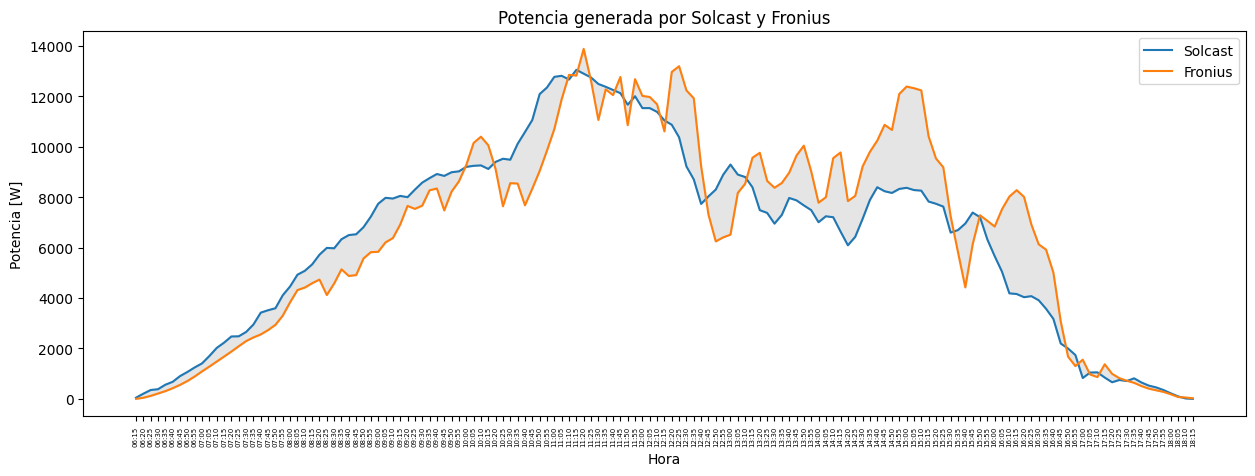

In [17]:
# suma de la potencia generada solcast
energia = df['P_cloud_opacity']*(5/60)
print("Energía calculada solacast [kWh] =",energia.sum()/1000)

# suma de la potencia generada fronius
energia_fronius = df['Potencia']*(5/60)
print("Energía calculada fronius [kWh] =",energia_fronius.sum()/1000)

# error porcentual
error = abs(  energia.sum() - energia_fronius.sum()) / energia_fronius.sum() * 100
print('Error porcentual:', error, '%')

# graficar la energía generada por solcast y fronius
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['P_cloud_opacity'], label='Solcast')
plt.plot(df['Time'], df['Potencia'], label='Fronius')
# grafico area bajo la curva
plt.fill_between(df['Time'], df['P_cloud_opacity'], df['Potencia'], color='gray', alpha=0.2)
plt.title('Potencia generada por Solcast y Fronius')
plt.xlabel('Hora')
plt.ylabel('Potencia [W]')
plt.legend()
plt.xticks(rotation=90, size=5)
plt.show()

## Potencia calulada teniendo en cuenta gti, nubosidad y temperatura del aire


# temperatura del aire

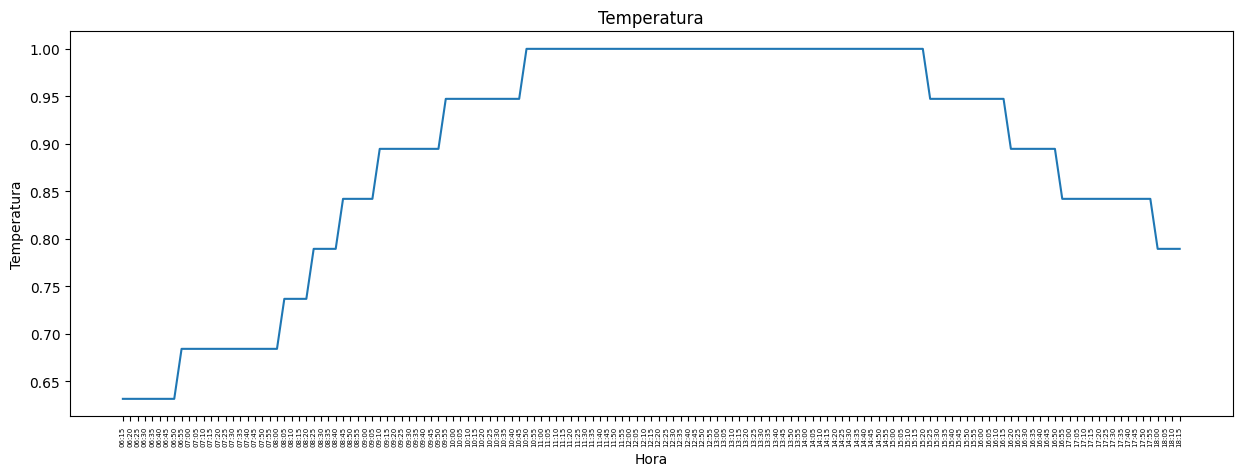

In [18]:
# normalizar 'air_temp' de 0 a 1  en donde 1 es el valor más alto
df['air_temp'] = df['air_temp'] / df['air_temp'].max()

# graficar la temperatura
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['air_temp'])
plt.title('Temperatura')
plt.xlabel('Hora')
plt.ylabel('Temperatura')
plt.xticks(rotation=90, size=5)
plt.show()

Energía calculada solacast [kWh] = 79.06994326991693
Energía calculada fronius [kWh] = 79.79673999999999
Error porcentual: 0.9108100532466166 %


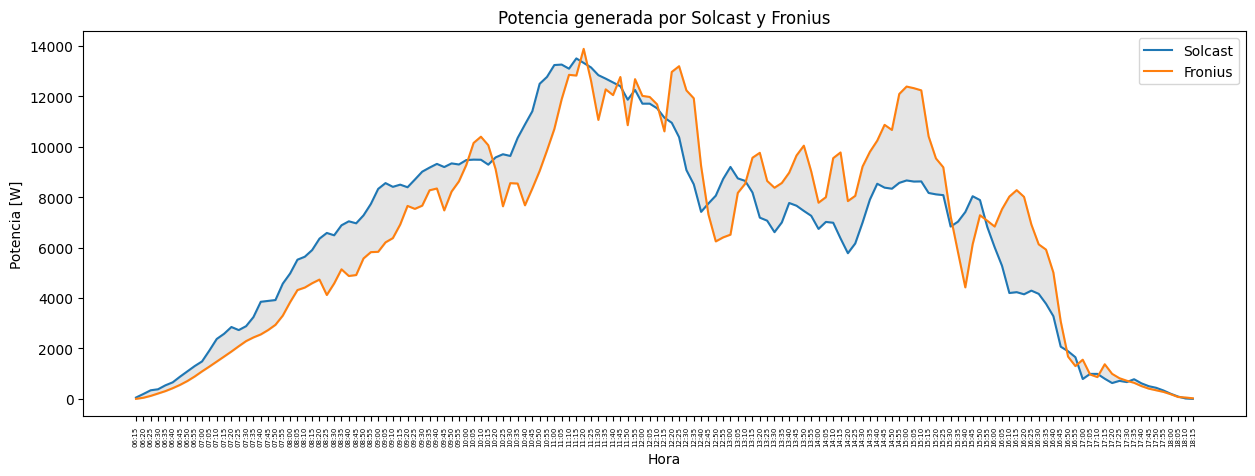

In [19]:
df['P_cloud_opacity_temp'] = df['GHI'] * efficiency *  area * catidad_pv * (1 - 0.5*df['cloud_opacity']) * (1 - 0.1*df['air_temp'])
# suma de la potencia generada solcast
energia = df['P_cloud_opacity_temp']*(5/60)
print("Energía calculada solacast [kWh] =",energia.sum()/1000)

# suma de la potencia generada fronius
energia_fronius = df['Potencia']*(5/60)
print("Energía calculada fronius [kWh] =",energia_fronius.sum()/1000)

# error porcentual
error = abs(  energia.sum() - energia_fronius.sum()) / energia_fronius.sum() * 100
print('Error porcentual:', error, '%')

# graficar la energía generada por solcast y fronius
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['P_cloud_opacity_temp'], label='Solcast')
plt.plot(df['Time'], df['Potencia'], label='Fronius')
# grafico area bajo la curva
plt.fill_between(df['Time'], df['P_cloud_opacity_temp'], df['Potencia'], color='gray', alpha=0.2)
plt.title('Potencia generada por Solcast y Fronius')
plt.xlabel('Hora')
plt.ylabel('Potencia [W]')
plt.legend()
plt.xticks(rotation=90, size=5)
plt.show()

## Modelo de optimización


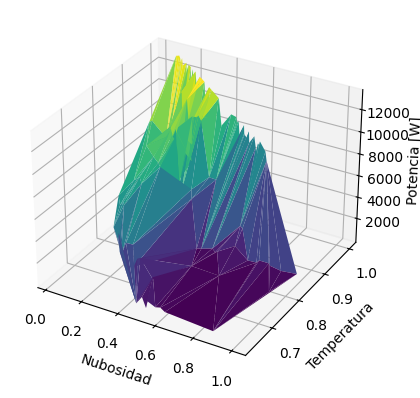

In [30]:
## grafico en 3d de superficie para Potencia cloud_opacity air_temp 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(df['cloud_opacity'], df['air_temp'], df['P_cloud_opacity_temp'], cmap='viridis')
ax.set_xlabel('Nubosidad')
ax.set_ylabel('Temperatura')
ax.set_zlabel('Potencia [W]')
plt.show()



In [28]:
from scipy.optimize import minimize
import numpy as np

# Función de error
def error_porcentual(alpha_beta):
    alpha, beta = alpha_beta
    efficiency = 0.2094  # Eficiencia del panel solar
    catidad_pv= 30
    area =2.274*1.134
    energia_calculada = df['GHI'] * efficiency * area * catidad_pv * (1 - beta * df['cloud_opacity']) * (1 - alpha * df['air_temp'])
    energia = energia_calculada * (5/60) / 1000  # Convertir a kWh
    energia_fronius = df['Potencia'] * (5/60) / 1000  # Convertir a kWh
    error = abs(energia.sum() - energia_fronius.sum()) / energia_fronius.sum() * 100
    return error

# Conjeturas iniciales para alpha y beta
guess = [0.5, 0.5]

# Optimización
resultado_optimizacion = minimize(error_porcentual, guess, bounds=[(0, 1), (0, 1)])

# Valores óptimos de alpha y beta
alpha_optimo, beta_optimo = resultado_optimizacion.x
print("Alpha óptimo:", alpha_optimo)
print("Beta óptimo:", beta_optimo)


Alpha óptimo: 0.18774287711817794
Beta óptimo: 0.1879053711192165
